# Summary Quality Metrics: Original vs Generated

Comparing the **original summaries** (from master_resumes_original.jsonl) with our **generated summaries** using the same metrics.

In [4]:
# Setup: Load both original and generated summaries
import json
import numpy as np

with open('original_summaries.json', 'r', encoding='utf-8') as f:
    original_summaries = json.load(f)

with open('generated_summaries.json', 'r', encoding='utf-8') as f:
    generated_summaries = json.load(f)


## Metric 1: Word Count Comparison

Are the summaries a reasonable length? Compare original vs generated.

In [5]:
# Word counts for both
original_wc = [len(s.split()) for s in original_summaries.values() if s.strip()]
generated_wc = [len(s.split()) for s in generated_summaries.values() if s.strip()]

print("WORD COUNT COMPARISON")
print(f"{'Metric':<20} {'Original':<15} {'Generated':<15}")
print("-"*50)
print(f"{'Average':<20} {np.mean(original_wc):.0f} words{'':<5} {np.mean(generated_wc):.0f} words")
print(f"{'Min':<20} {np.min(original_wc):<15} {np.min(generated_wc):<15}")
print(f"{'Max':<20} {np.max(original_wc):<15} {np.max(generated_wc):<15}")
print(f"{'Too short (<30)':<20} {sum(1 for w in original_wc if w < 30):<15} {sum(1 for w in generated_wc if w < 30):<15}")

WORD COUNT COMPARISON
Metric               Original        Generated      
--------------------------------------------------
Average              20 words      60 words
Min                  1               20             
Max                  109             90             
Too short (<30)      4685            2              


## Metric 2: Content Similarity to Resume (Semantic Similarity)

Content Similarity to Resume (Semantic Similarity)
This metric measures how semantically similar the summary is to the actual resume content. It answers the question: "Does this summary actually capture the meaning of the resume?"
1. What is it?
It is a Semantic Similarity Score calculated using a deep learning embedding model (all-MiniLM-L6-v2).
Semantic: It looks at the meaning of the text, not just matching keywords. For example, "Software Engineer" and "Developer" would have high similarity, even though they are different words.
Similarity: A number representing how close the two texts are in meaning.
2. How is it calculated?
The calculation follows these three steps:
Step A: Prepare the Data
Source Text (Resume): It concatenates three key fields from the resume into one long string:
experience (Job history)
skills (Technical skills)
projects (Project descriptions)
Target Text (Summary): The summary being evaluated (either the Original or the Generated one).
Step B: Convert Text to Numbers (Embeddings)
It uses a pre-trained Transformer model called all-MiniLM-L6-v2 from the sentence-transformers library.
This model takes a piece of text (like the resume or the summary) and converts it into a dense vector (a list of 384 numbers).
This vector represents the "meaning" of the text in a multi-dimensional space.
Step C: Calculate Similarity (Cosine Similarity)
It compares the Resume Vector vs. the Summary Vector using Cosine Similarity.
Cosine Similarity: Measures the cosine of the angle between two vectors.
1.0: Perfect match (The summary means exactly the same thing as the resume).
0.0: No correlation (The summary is completely unrelated).
-1.0: Opposite meaning (Rare in this context).
3. Interpretation of Scores
Higher Score is Better: A higher score means the summary effectively captures the core content of the resume.
Original (0.350): The low score suggests the original summaries might be generic, very short, or contain info not found in the resume body.
Generated (0.660): The higher score suggests the AI-generated summaries are much more grounded in the actual resume data, reflecting the specific experience and skills listed.

In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load semantic embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load resume data
df = pd.read_csv('cleaned_resumes.csv')

# Combine resume fields as the "source" text
df['resume_text'] = df['experience'].fillna('') + " " + df['skills'].fillna('') + " " + df['projects'].fillna('')

# Map summaries to dataframe
df['original_summary'] = df.index.astype(str).map(original_summaries).fillna('')
df['generated_summary'] = df.index.astype(str).map(generated_summaries).fillna('')

# Calculate semantic similarity for sample (first 1000)
sample = df.head(1000)

orig_sims, gen_sims = [], []
for idx, row in sample.iterrows():
    if row['resume_text'].strip() and row['original_summary'].strip():
        embeddings = model.encode([row['resume_text'], row['original_summary']])
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        orig_sims.append(sim)
    if row['resume_text'].strip() and row['generated_summary'].strip():
        embeddings = model.encode([row['resume_text'], row['generated_summary']])
        sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        gen_sims.append(sim)

print("SEMANTIC SIMILARITY TO RESUME")
print(f"{'Metric':<20} {'Original':<15} {'Generated':<15}")
print("-" * 40)
print(f"{'Mean Similarity':<20} {np.mean(orig_sims):.3f}{'':<10} {np.mean(gen_sims):.3f}")

c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Rane\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


SEMANTIC SIMILARITY TO RESUME
Metric               Original        Generated      
----------------------------------------
Mean Similarity      0.350           0.660


## Distribution Visualization

Visual comparison of both metrics.

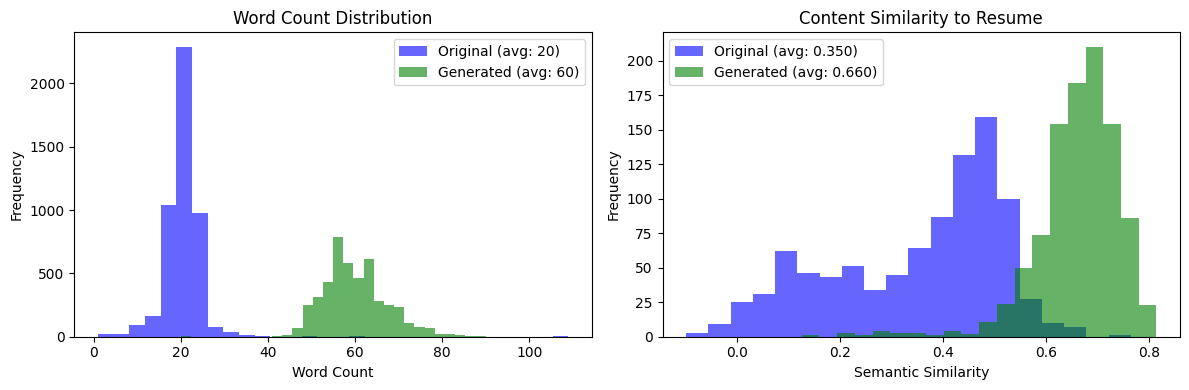

: 

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Word Count Distribution
axes[0].hist(original_wc, bins=30, alpha=0.6, label=f'Original (avg: {np.mean(original_wc):.0f})', color='blue')
axes[0].hist(generated_wc, bins=30, alpha=0.6, label=f'Generated (avg: {np.mean(generated_wc):.0f})', color='green')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Word Count Distribution')
axes[0].legend()

# Similarity Distribution
axes[1].hist(orig_sims, bins=20, alpha=0.6, label=f'Original (avg: {np.mean(orig_sims):.3f})', color='blue')
axes[1].hist(gen_sims, bins=20, alpha=0.6, label=f'Generated (avg: {np.mean(gen_sims):.3f})', color='green')
axes[1].set_xlabel('Semantic Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Content Similarity to Resume')
axes[1].legend()

plt.tight_layout()
plt.show()